In [1]:
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
width_shape, height_shape = 128, 128 # Tamaño de las imagenes de entrada para el resize
batch_size = 20
epochs = 20
data_path_train = "/content/drive/MyDrive/Data/train_proy4/"    # Directorio de las imágenes y mascaras de entrenamiento
data_path_test = "/content/drive/MyDrive/Data/test_proy3/"      # Directorio de las imágenes de pruebas

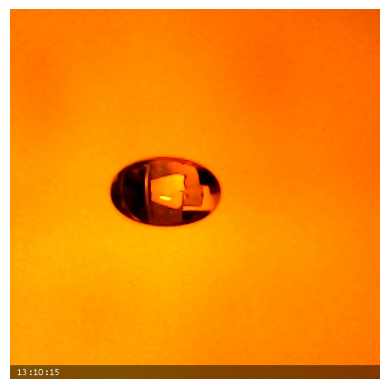

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Ruta de la imagen
image_path = '/content/drive/MyDrive/Data/test_proy3/1/images/1.png'

# Cargar la imagen
image = Image.open(image_path)

# Mostrar la imagen de prueba
plt.imshow(image)
plt.axis('off')  # Desactivar ejes
plt.show()

In [7]:
#Preprocesamiento para verificar dimensiones
#Muy importante en TensorFlow verificar dimensiones

from PIL import Image

def obtener_info_imagen(ruta_imagen):
    # Abrir la imagen
    imagen = Image.open(ruta_imagen)

    # Obtener el modo de la imagen (L para blanco y negro, RGB para color)
    modo = imagen.mode

    # Obtener el tamaño de la imagen
    ancho, alto = imagen.size

    # Mostrar la información
    print(f"Modo de la imagen: {modo}")
    print(f"Tamaño de la imagen: {ancho} x {alto}")

    # Devolver el modo y tamaño
    return modo, (ancho, alto)

# Ejemplo de uso
ruta_ejemplo_imagen = "/content/drive/MyDrive/Data/train_proy4/1/masks/1.png"
modo, tamano = obtener_info_imagen(ruta_ejemplo_imagen)


Modo de la imagen: L
Tamaño de la imagen: 480 x 480


In [8]:
if len(modo) == 1:
    print("La imagen es en blanco y negro.")
elif len(modo) == 3:
    print("La imagen es a color (RGB).")
else:
    print("El modo de la imagen no es reconocido.")

La imagen es en blanco y negro.


In [10]:
# obtenemos una lista con los archivos dentro de cada carpeta
data_list_train = os.listdir(data_path_train)
data_list_test = os.listdir(data_path_test)

# Definimos listas para guardar cada elemento del dataset
Xtrain=[]
Ytrain=[]
Xtest=[]

# Recorremos la carpeta train
for folder in tqdm(data_list_train):
    # Leemos cada imagen del dataset de entrenamiento y la redimensionamos
    img = imread(data_path_train +folder+ '/images/'  + folder+'.png')[:,:,:3]
    img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
    # Agregamos cada imagen a la lista Xtrain
    Xtrain.append(img)

    # Creamos una mascarar de zeros
    mask = np.zeros((height_shape, width_shape, 1), dtype=np.bool)
    # Guardamos en una lista todos los archivos en el directorio masks de entrenamiento
    data_list_mask = os.listdir(data_path_train+folder+'/masks/')
    # Recorremos todos los archivos dentro del directorio de masks
    for name_file in data_list_mask:
        # Leemos cada una de las mascaras binarias y las redimensionamos
        maskt = imread(data_path_train +folder+ '/masks/'  + name_file)
        maskt = resize(maskt, (height_shape, width_shape),mode='constant', preserve_range=True)
        maskt = np.expand_dims(maskt, axis=-1)
        # Unimos la mascara actual con la anterior (equivalente a una operación OR)
        mask = np.maximum(mask, maskt)

    # Agregamos cada mascara a la lista Ytrain
    Ytrain.append(mask)

# Recorremos la carpeta test
for folder in tqdm(data_list_test):
    # leemos cada imagen del dataset de prueba y la redimensionamos
    img = imread(data_path_test +folder+ '/images/'  + folder+'.png')[:,:,:3]
    img = resize(img, (height_shape, width_shape),mode='constant', preserve_range=True)
    # Agregamos cada imagen a la lista Xtest
    Xtest.append(img)

X_train = np.asarray(Xtrain,dtype=np.uint8)
print('Xtrain:',X_train.shape)

Y_train = np.asarray(Ytrain,dtype=np.bool)
print('Ytrain:',Y_train.shape)

X_test = np.asarray(Xtest,dtype=np.uint8)
print('Xtest:',X_test.shape)

  0%|          | 0/150 [00:00<?, ?it/s]<ipython-input-10-3fb10163b1b9>:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((height_shape, width_shape, 1), dtype=np.bool)
100%|██████████| 150/150 [00:05<00:00, 27.87it/s]

Xtrain: (150, 128, 128, 3)
Ytrain: (150, 128, 128, 1)
Xtest: (150, 128, 128, 3)



<ipython-input-10-3fb10163b1b9>:45: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.asarray(Ytrain,dtype=np.bool)


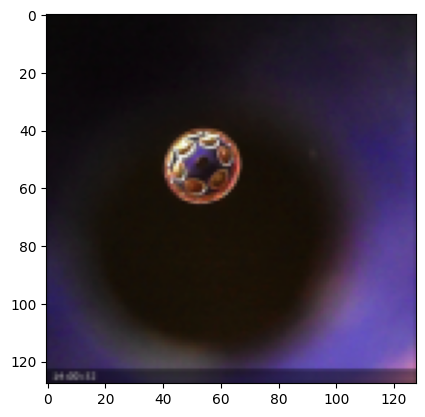

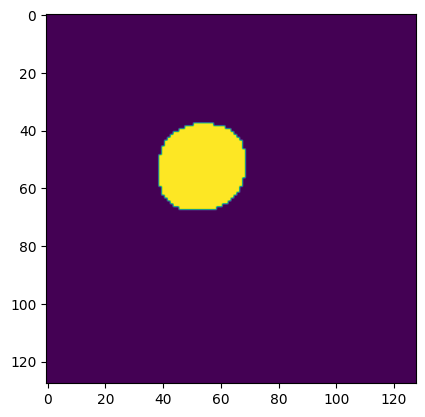

In [11]:
# Mostramos la imagen y su mascara asociada
plt.imshow(X_train[0])
plt.show()
plt.imshow((Y_train[0]))
plt.show()

In [12]:
# Definimos la entrada al modelo
Image_input = Input((height_shape, width_shape, 3))
Image_in = Lambda(lambda x: x / 255)(Image_input) #normalización

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Image_in) #'same'-> Relleno para mantener las dimensiones
#64 filtros, convolución de 3x3
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5) #Conv2DTranspose --> Deconvolución
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #conv de 1x1 para la salida

model = Model(inputs=[Image_input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['lambda[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                              

In [13]:
# Definimos la entrada al modelo

#Con drop Out para evitar overfitting(sobreajuste)

inputs = Lambda(lambda x: x / 255)(Input((height_shape, width_shape, 3)))

#contracting path
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Dropout(0.1)(conv1) #desactiva un 10% de las neuronas en la capa donde se aplica el drop out
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Dropout(0.1)(conv2)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Dropout(0.2)(conv6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Dropout(0.2)(conv7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Dropout(0.1)(conv8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Dropout(0.1)(conv9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 128, 128, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 64)         0         ['conv2d_19[1][0]']           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 128, 128, 64)         36928     ['dropout[1][0]']             
                                                                                            

In [14]:
from tensorflow.keras.callbacks import TensorBoard

# Cargamos la extensión, definimos la carpeta logs para guardar los datos de entrenamiento, y definimos el callback
%load_ext tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [15]:
#entrenamos el modelo
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 42s 3s/step - loss: 1.6188 - accuracy: 0.8440 - val_loss: 0.3996 - val_accuracy: 0.9481
Epoch 2/20
7/7 [==============================] - 9s 2s/step - loss: 0.5366 - accuracy: 0.8929 - val_loss: 0.2675 - val_accuracy: 0.9686
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.2494 - accuracy: 0.9474 - val_loss: 0.1657 - val_accuracy: 0.9852
Epoch 4/20
7/7 [==============================] - 10s 2s/step - loss: 0.1980 - accuracy: 0.9630 - val_loss: 0.1297 - val_accuracy: 0.9854
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.1710 - accuracy: 0.9722 - val_loss: 0.1029 - val_accuracy: 0.9902
Epoch 6/20
7/7 [==============================] - 12s 2s/step - loss: 0.1347 - accuracy: 0.9747 - val_loss: 0.0918 - val_accuracy: 0.9898
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.1485 - accuracy: 0.9712 - val_loss: 0.0622 - val_accuracy: 0.9906
Epoch 8/20
7/7 [======================

In [16]:
%reload_ext tensorboard
%tensorboard --logdir logs --host localhost

Launching TensorBoard...

5/5 [==============================] - 7s 802ms/step


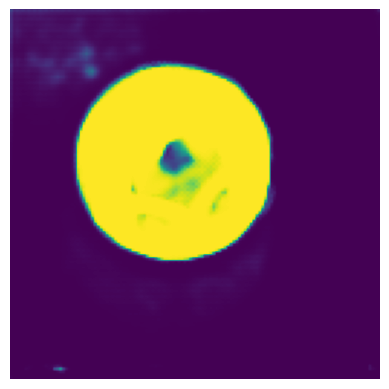

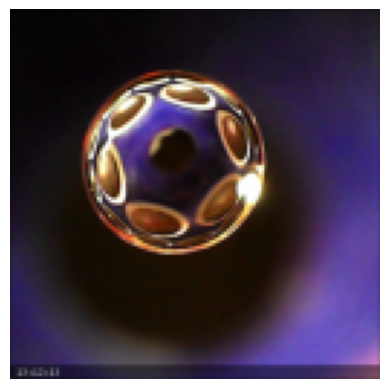

In [17]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[1]))
plt.axis('off')
plt.show()
plt.imshow(X_test[1])
plt.axis('off')
plt.show()

In [18]:
model.save('Model_U_Net_LevDrop.h5')

# Para cargar el modelo más tarde
Modelo_ = tf.keras.models.load_model('Model_U_Net_LevDrop.h5')

#model.save("/content/drive/MyDrive/")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 1s 117ms/step


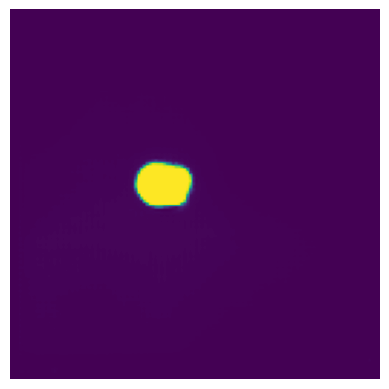

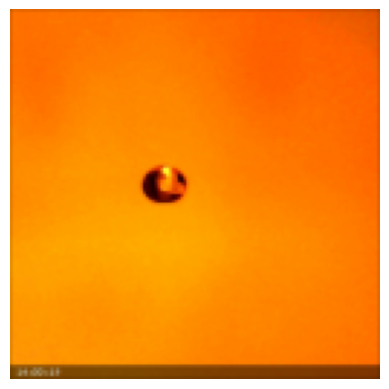

In [19]:
preds = Modelo_.predict(X_test)
plt.imshow(np.squeeze(preds[145]))
plt.axis('off')
plt.show()

plt.imshow(X_test[145])
plt.axis('off')
plt.show()

5/5 [==============================] - 1s 122ms/step


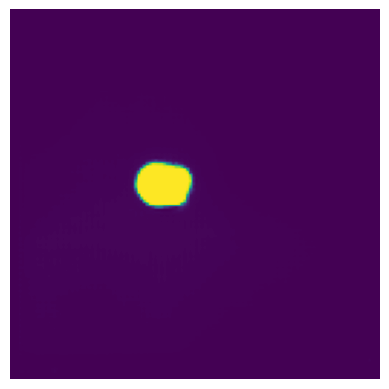

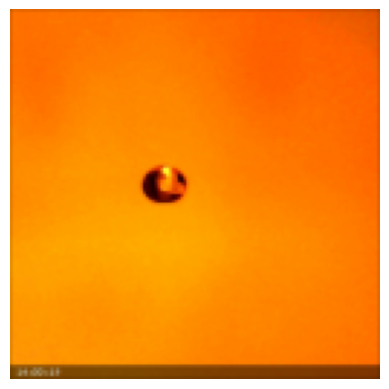

In [20]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[145]))
plt.axis('off')
plt.show()
plt.imshow(X_test[145])
plt.axis('off')
plt.show()

5/5 [==============================] - 0s 117ms/step


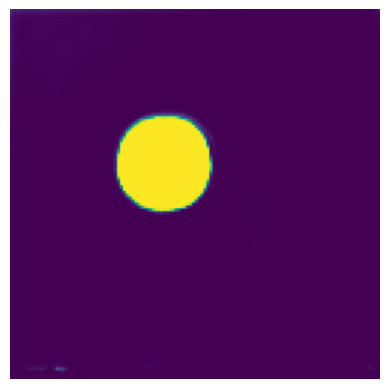

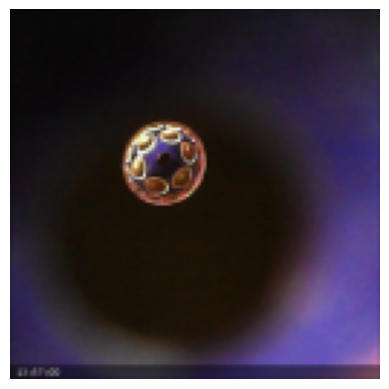

In [21]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[149]))
plt.axis('off')
plt.show()
plt.imshow(X_test[149])
plt.axis('off')
plt.show()

5/5 [==============================] - 0s 117ms/step


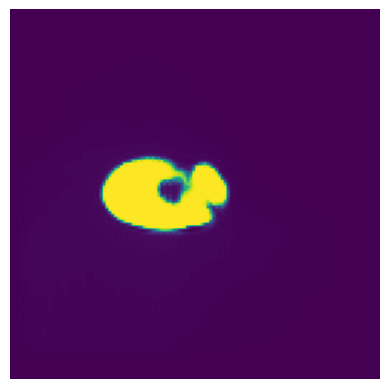

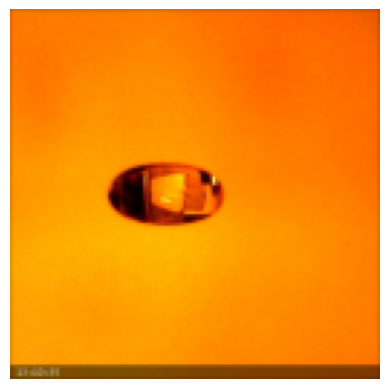

In [22]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[136]))
plt.axis('off')
plt.show()
plt.imshow(X_test[136])
plt.axis('off')
plt.show()

5/5 [==============================] - 1s 122ms/step


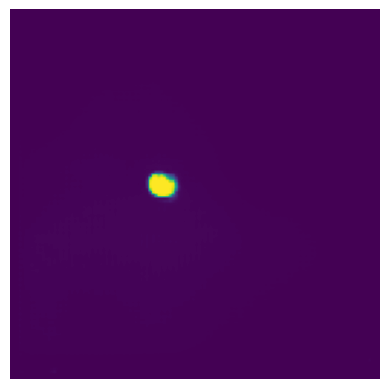

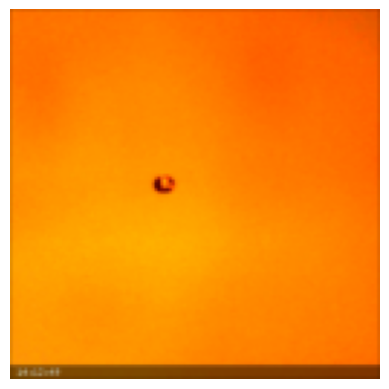

In [23]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[35]))
plt.axis('off')
plt.show()
plt.imshow(X_test[35])
plt.axis('off')
plt.show()

5/5 [==============================] - 0s 117ms/step


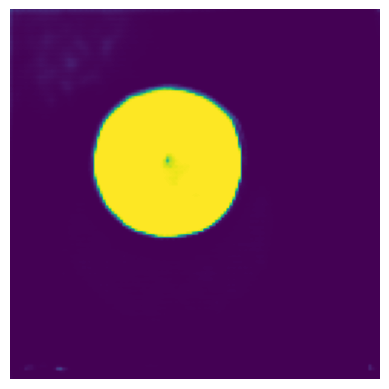

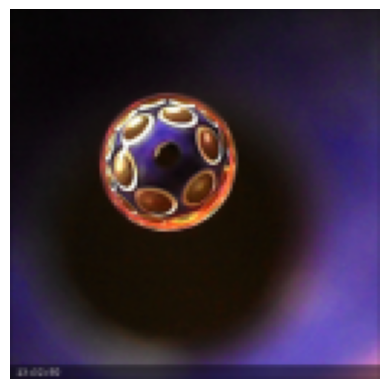

In [24]:
#probamos el modelo con alguna imágen de prueba
preds = model.predict(X_test)
plt.imshow(np.squeeze(preds[118]))
plt.axis('off')
plt.show()
plt.imshow(X_test[118])
plt.axis('off')
plt.show()

In [25]:
prueba=preds[149]
prueba_org=X_test[149]

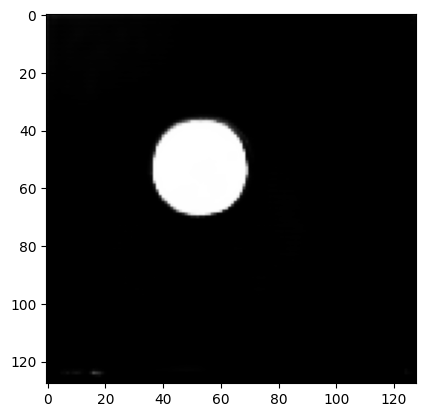

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que 'prueba' es la imagen que deseas procesar
# y 'prueba_org' es la imagen original

# Verificar si 'prueba' ya está en escala de grises
if len(prueba.shape) == 3 and prueba.shape[2] == 3:
    # Convertir a escala de grises si es una imagen en color
    grayscale_prueba = cv2.cvtColor(prueba, cv2.COLOR_BGR2GRAY).astype(np.uint8)
else:
    # Si ya está en escala de grises, no es necesario convertir
    grayscale_prueba = prueba.astype(np.uint8)

# Aplicar un filtro de detección de bordes (por ejemplo, Canny)
edges = cv2.Canny(grayscale_prueba, 150, 400)

# Encontrar contornos en los bordes
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar círculo en cada contorno
for contour in contours:
    # Encontrar el centro y el radio del círculo mínimo que encierra el contorno
    if len(contour) >= 5:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(prueba, center, radius, (0, 255, 0), 2)  # Dibujar el círculo en la imagen original

# Mostrar la imagen con los bordes y círculos verdes
plt.imshow(cv2.cvtColor(prueba, cv2.COLOR_BGR2RGB))
plt.show()
